# Problem Description
## 

# Load the Data into disk

In [ ]:
# download the datasets

import os
import opendatasets as od
import pandas as pd
import json

data_path = "./pii-detection-removal-from-educational-data/"

# download the data from kaggle
if not os.path.exists(data_path):
    print("Dataset not found, downloading from Kaggle")
    dataset = "https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/data"
    od.download(dataset)
else:
    print("Dataset found in disk")

# check for the files present there
assert os.path.exists(data_path + "train.json"), "train.json file missing"
assert os.path.exists(data_path + "test.json"), "test.json file missing"


train_df = pd.read_json(open(data_path + "train.json"))
print("train_df loaded")

test_df = pd.read_json(open(data_path + "test.json"))
print("test_df loaded")

Dataset found in disk
train_df loaded
test_df loaded


In [54]:
train_df_expl = train_df.copy()

def create_token_list(token_list):
  return list(range(len(token_list)))  # Create list based on current list length

train_df_expl["token"] = train_df_expl["tokens"].apply(create_token_list)

train_df_expl = train_df_expl.explode(["tokens", "labels", 'token'], ignore_index=True)

display(train_df_expl.head(5))

,document,full_text,tokens,trailing_whitespace,labels,token
0,7,Design Thinking for innovation reflexion-Avril...,Design,"[True, True, True, True, False, False, True, F...",O,0
1,7,Design Thinking for innovation reflexion-Avril...,Thinking,"[True, True, True, True, False, False, True, F...",O,1
2,7,Design Thinking for innovation reflexion-Avril...,for,"[True, True, True, True, False, False, True, F...",O,2
3,7,Design Thinking for innovation reflexion-Avril...,innovation,"[True, True, True, True, False, False, True, F...",O,3
4,7,Design Thinking for innovation reflexion-Avril...,reflexion,"[True, True, True, True, False, False, True, F...",O,4


# EDA

## General Questions about Dataset

### 1) what is the distribution of number of tokens based on documents?
- The data is right skewed. There are more documents with the number of tokens between 500 and 1000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


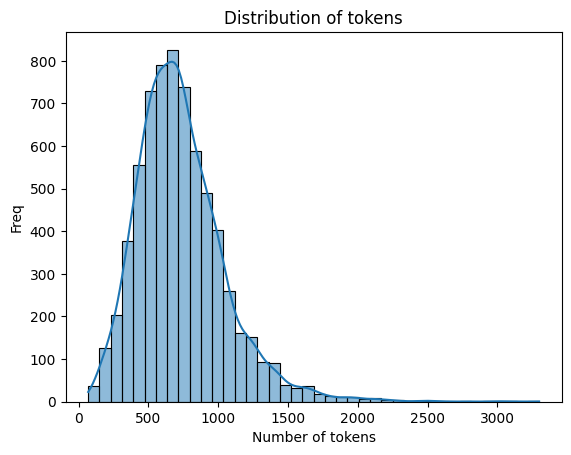

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

tmp_df = train_df.copy()

tmp_df["num_tokens"] = tmp_df["tokens"].apply(len)

sns.histplot(tmp_df["num_tokens"], bins = 40, kde=True)
plt.title("Distribution of tokens")
plt.xlabel("Number of tokens")
plt.ylabel("Freq")
plt.show()

### 2) Total number of unique words in the data?
- there are 53,985 unique words in the training document

In [11]:
unique_words = tmp_df["tokens"].explode().unique().tolist()
print("Total unique words : ", len(unique_words))

Total unique words :  53985


### 3) Unique types of labels ?
- "Email" and "USERNAME" doesn't have a "Inner flag. 
- so the tokenizer doesn't split up email and username
- A simple regex can be used to identify the email and username


In [12]:
unique_labels = tmp_df["labels"].explode().unique().tolist()
unique_labels = sorted(unique_labels, key=lambda x : x.split("-")[1] if x != "O" else "")
print("List of Unique Labels : \n")
print(unique_labels)

List of Unique Labels : 

['O', 'B-EMAIL', 'B-ID_NUM', 'I-ID_NUM', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-PHONE_NUM', 'I-PHONE_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS', 'B-URL_PERSONAL', 'I-URL_PERSONAL', 'B-USERNAME']


> Frequency of the unique labels in the dataset
- NAME_STUDENT has the highest frequency among all the labels
- USERNAME has the lowest frequency among all the labels


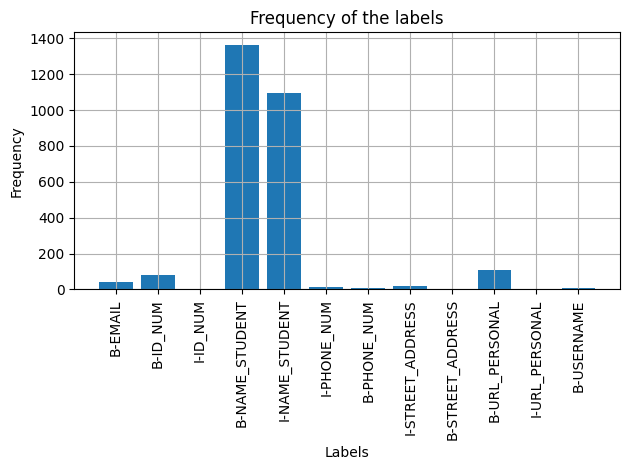

In [13]:
unique_labels = tmp_df["labels"].explode().value_counts().to_dict()
unique_labels = dict(sorted(unique_labels.items(), key=lambda x : x[0].split("-")[1] if x[0] != "O" else ""))
del unique_labels["O"]

plt.bar(unique_labels.keys(), unique_labels.values())

plt.title("Frequency of the labels")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

## Deep Dive : EMAIL
Since the email has only the "B" token associated with it, we can use a regex easily as email often comes with a pattern
### Example for Emails
- sample@gmail.com
- xyz@yahoo.com
- abcd.efgh@abcd.eu

The below code is a regex matcher for retriving emails

### Function

In [55]:
import re

def is_email(text):
    # Regular expression pattern for matching email addresses
    pattern = r'^[\w\.-]+@[\w\.-]+\.\w+$'
    return re.match(pattern, text) is not None

email = "example@email.com"
non_email = "notanemail.com"

print(is_email(email))    
print(is_email(non_email)) 

def get_all_emails_from_text(df_exploded):
    output = {
        "document" : [],
        "token" : [], 
        "label" : []
    }

    _label = "B-EMAIL"
    
    for document, token, token_id in zip(df_exploded["document"], df_exploded["tokens"], df_exploded["token"]):
        if is_email(token):
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label)
    return output


output = get_all_emails_from_text(train_df_expl)
print(output)

True
False
{'document': [379, 2769, 3709, 3709, 4227, 4227, 4381, 4438, 4438, 4465, 4777, 5263, 5397, 6243, 6243, 6243, 6577, 6577, 6611, 6900, 6900, 7308, 7308, 7308, 7308, 8344, 8642, 9146, 9146, 9854, 10945, 10945, 11301, 11301, 11859, 11954, 11954, 11954, 12989, 14484], 'token': [28, 22, 53, 55, 3, 526, 23, 12, 578, 871, 439, 40, 17, 7, 438, 465, 3, 634, 5, 12, 469, 3, 5, 380, 382, 14, 4, 69, 248, 21, 1, 549, 0, 441, 7, 15, 23, 610, 6, 294], 'label': ['B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL', 'B-EMAIL']}


## Deep Dive : USERNAME

### Examples

In [15]:
usernames = tmp_df.explode(["labels", "tokens"]).reset_index()
usernames = usernames[usernames["labels"] == "B-USERNAME"]["tokens"].tolist()
usernames

['castanedagabriel',
 'fdixon',
 'fdixon',
 'meyermichelle',
 'jacob59',
 'holmespatrick']

### Function

In [57]:
# function to check
USERNAMES = ['castanedagabriel', 'fdixon', 'fdixon', 'meyermichelle', 'jacob59', 'holmespatrick']
USERNAMES = ['castanedagabriel', 'fdixon', 'fdixon']


def is_username(token):
    if token in USERNAMES:
        return True
    return False

def get_all_usernames_from_text(df_exploded):
    output = {
        "document" : [],
        "token" : [], 
        "label" : []
    }

    _label = "B-USERNAME"

    for document, token, token_id in zip(df_exploded["document"], df_exploded["tokens"], df_exploded["token"]):
        if is_email(token):
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label)
    return output

output = get_all_usernames_from_text(train_df_expl)
print(output)

{'document': [379, 2769, 3709, 3709, 4227, 4227, 4381, 4438, 4438, 4465, 4777, 5263, 5397, 6243, 6243, 6243, 6577, 6577, 6611, 6900, 6900, 7308, 7308, 7308, 7308, 8344, 8642, 9146, 9146, 9854, 10945, 10945, 11301, 11301, 11859, 11954, 11954, 11954, 12989, 14484], 'token': [28, 22, 53, 55, 3, 526, 23, 12, 578, 871, 439, 40, 17, 7, 438, 465, 3, 634, 5, 12, 469, 3, 5, 380, 382, 14, 4, 69, 248, 21, 1, 549, 0, 441, 7, 15, 23, 610, 6, 294], 'label': ['B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-US

## Deep Dive : ID_NUM
### Example of ID_NUM

In [60]:
id_num = tmp_df.explode(["labels", "tokens"]).reset_index()
id_num_b = id_num[id_num["labels"] == "B-ID_NUM"]["tokens"].tolist()
id_num_i = id_num[id_num["labels"] == "I-ID_NUM"]["tokens"].tolist()

print(f"B-ID_NUM ({len(list(set(id_num_b)))} / {len(id_num_b)}) : ", id_num_b[:10])
print(f"I-ID_NUM ({len(list(set(id_num_i)))} / {len(id_num_i)}) : ", id_num_i[:10])

len_id_num_b = id_num[id_num["labels"] == "B-ID_NUM"]
len_id_num_b["length"] = len_id_num_b["tokens"].str.len()
len_id_num_b["length"].value_counts(sort="asc")

B-ID_NUM (67 / 78) :  ['860632713425', '530670102508', '530670102508', '875673967537', '860632713425', '557349702179', '784372734211', '054176622314', '674915248960', '932353568953']
I-ID_NUM (1 / 1) :  ['30407059']


/var/folders/bl/78xnml8j3qj74t4c1j3s2jhw0000gn/T/ipykernel_65716/504296862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  len_id_num_b["length"] = len_id_num_b["tokens"].str.len()


length
12    55
15     5
16     3
19     2
6      2
9      2
7      2
8      1
11     1
13     1
10     1
5      1
18     1
4      1
Name: count, dtype: int64

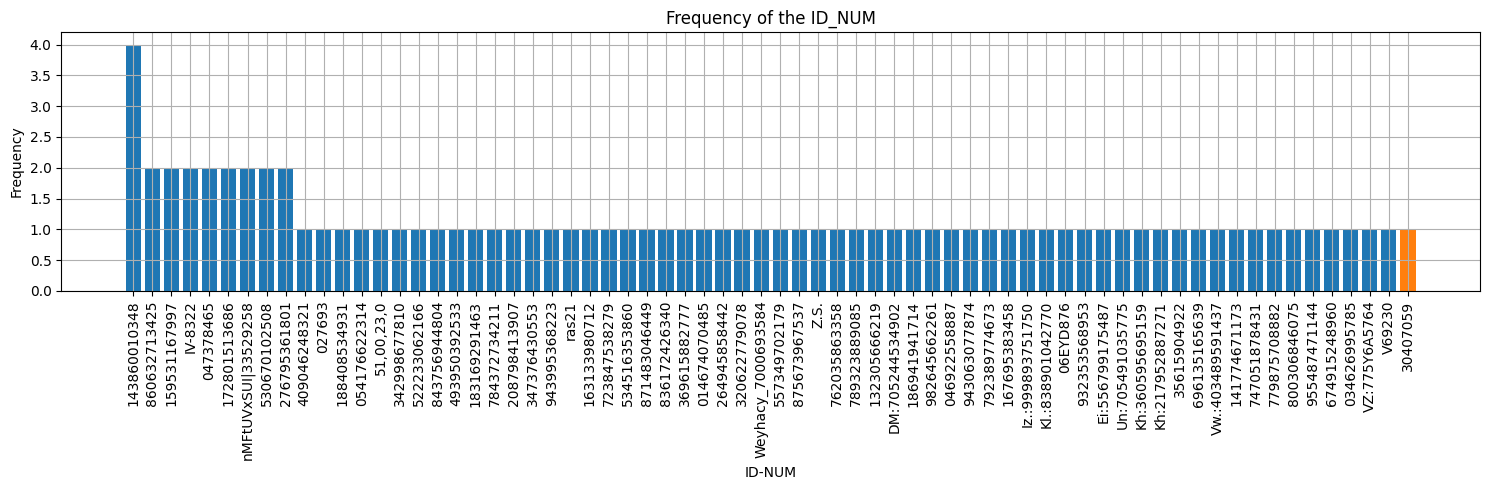

In [61]:
id_num_b = id_num[id_num["labels"] == "B-ID_NUM"]["tokens"].value_counts()
id_num_i = id_num[id_num["labels"] == "I-ID_NUM"]["tokens"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(id_num_b.index, id_num_b)
plt.bar(id_num_i.index, id_num_i)

plt.title("Frequency of the ID_NUM")
plt.xlabel("ID-NUM")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Function

In [66]:
def get_all_idnum_from_text(df_exploded):
    output = {
        "document" : [],
        "token" : [], 
        "label" : []
    }

    _label = "B-USERNAME"

    for document, token, token_id in zip(df_exploded["document"], df_exploded["tokens"], df_exploded["token"]):
        if str(token).isnumeric() and len(token) > 10:
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label)
    return output

output = get_all_idnum_from_text(train_df_expl)
print(output)

{'document': [609, 609, 609, 609, 609, 609, 609, 609, 609, 2926, 3565, 3565, 4717, 4717, 4717, 4717, 4913, 4913, 4913, 4971, 4971, 4971, 5606, 5606, 5606, 5606, 5653, 5796, 6450, 6450, 6537, 6537, 6537, 6591, 6591, 6849, 7156, 7156, 8714, 8751, 9460, 9493, 9493, 9543, 9543, 9760, 9760, 9760, 9760, 9760, 11900, 11900, 11900, 11900, 12184, 12184, 12184, 12184], 'token': [26, 39, 50, 56, 62, 68, 74, 80, 89, 9, 26, 33, 7, 18, 205, 337, 15, 46, 52, 519, 562, 620, 20, 264, 566, 791, 112, 24, 25, 32, 12, 21, 30, 12, 448, 16, 23, 40, 10, 706, 38, 457, 526, 25, 32, 8, 226, 245, 312, 401, 3, 243, 333, 371, 6, 325, 389, 430], 'label': ['B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-USERNAME', 'B-

## Deep Dive : NAME_STUDENT
### Example for NAME-STUDENT

In [91]:
name_stud = tmp_df.explode(["labels", "tokens"]).reset_index()
name_stud_b = name_stud[name_stud["labels"] == "B-NAME_STUDENT"]["tokens"].tolist()
name_stud_i = name_stud[name_stud["labels"] == "I-NAME_STUDENT"]["tokens"].tolist()

print(f"B-NAME_STUDENT ({len(list(set(name_stud_b)))} / {len(name_stud_b)}) : ", name_stud_b[:10])
print(f"I-NAME_STUDENT ({len(list(set(name_stud_i)))} / {len(name_stud_i)}) : ", name_stud_i[:10])

B-NAME_STUDENT (685 / 1365) :  ['Nathalie', 'Nathalie', 'Nathalie', 'Diego', 'Diego', 'Gilberto', 'Sindy', 'Nadine', 'Eladio', 'Silvia']
I-NAME_STUDENT (643 / 1096) :  ['Sylla', 'Sylla', 'Sylla', 'Estrada', 'Estrada', 'Gamboa', 'Samaca', 'Born', 'Amaya', 'Villalobos']


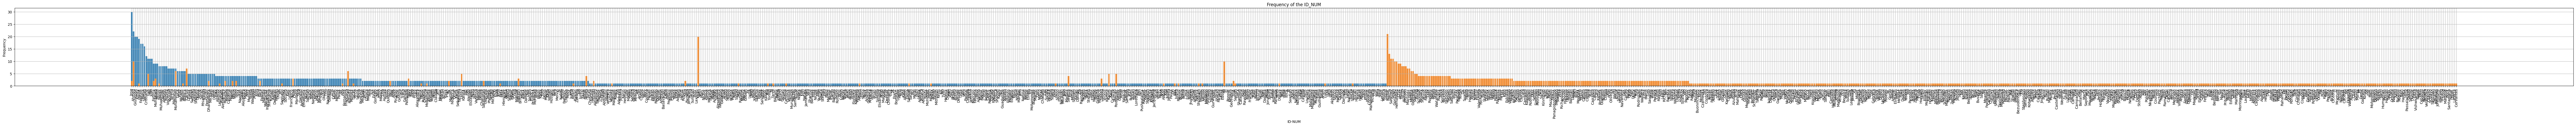

In [92]:
name_stud_b = name_stud[name_stud["labels"] == "B-NAME_STUDENT"]["tokens"].value_counts()
name_stud_i = name_stud[name_stud["labels"] == "I-NAME_STUDENT"]["tokens"].value_counts()

plt.figure(figsize=(100,5))
plt.bar(name_stud_b.index, name_stud_b)
plt.bar(name_stud_i.index, name_stud_i)


plt.title("Frequency of the ID_NUM")
plt.xlabel("ID-NUM")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Function

In [98]:
# function to check
B_NAME_STUD = ['Jose', 'Ahmed', 'Giuseppe', 'Emily', 'David', 'Fabrizio', 'Maria',
       'Saman', 'Cristiane', 'Luis', 'Md', 'Juan', 'Fatima', 'Mohamed',
       'Abdul', 'Naser', 'Muhammad', 'Daniel', 'Antonio', 'Ashley', 'Vincenzo',
       'Youssef', 'Teresa', 'Matheus', 'Mohammed', 'Luca', 'Vijay', 'Miriam',
       'Mauro', 'Blanca', 'Carlos', 'Liliana', 'Linda', 'Sullivan', 'Zahida',
       'Stephen', 'Diana', 'Anne', 'Sarah', 'Rhiannon', 'Junaid', 'Fernando',
       'Dharmendra', 'Michael', 'Bilal', 'Diego', 'Irina', 'Alberto',
       'Leonardo', 'Prakash']

I_NAME_STUD = ['Kumar', 'Khan', 'Garcia', 'Sanchez', 'Singh', 'Ahmed', 'Ali',
       'Gonzalez', 'Hernandez', 'Cruz', 'Perez', 'Torres', 'Kumari', 'Johnson',
       'Martinez', 'Lopez', 'Carlos', 'Ahmad', 'Mohammed', 'Medina',
       'Gonzales', 'Rodriguez', 'Leroy', 'Luis', 'Karim', 'Shende', 'Young',
       'James', 'Schmidt', 'Pandey', 'Sharma', 'Russo', 'Farrag', 'Dias',
       'Romero', 'Marie', 'Yadav', 'Taylor', 'Watanabe', 'Rivera', 'Silva',
       'Serrano', 'Jackson', 'Swetha', 'Laitinen', 'Hassan', 'Santos',
       'Sanches', 'Sajid', 'Smith']

def is_name_stud(token):
    if token in B_NAME_STUD:
        return "B"
    if token in I_NAME_STUD:
        return "I"
    return None

def get_all_name_from_text(df_exploded):
    output = {
        "document" : [],
        "token" : [], 
        "label" : []
    }

    _label1 = "B-NAME_STUDENT"
    _label2 = "I-NAME_STUDENT"


    for document, token, token_id in zip(df_exploded["document"], df_exploded["tokens"], df_exploded["token"]):
        tout = is_name_stud(token)
        if tout == "B":
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label1)
        elif tout == "I":
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label2)
    return output

output = get_all_name_from_text(train_df_expl)
print(output)

{'document': [10, 10, 104, 112, 123, 123, 123, 123, 288, 308, 308, 308, 308, 356, 375, 379, 379, 470, 607, 609, 609, 609, 609, 609, 609, 609, 616, 730, 730, 730, 1105, 1105, 1105, 1105, 1105, 1105, 1105, 1105, 1175, 1175, 1210, 1210, 1210, 1210, 1210, 1210, 1239, 1290, 1290, 1437, 1444, 1444, 1477, 1549, 1758, 1790, 1795, 1795, 1798, 1798, 1798, 1802, 1802, 1802, 1817, 1824, 2054, 2651, 2651, 2672, 2694, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2722, 2790, 2792, 2792, 2792, 2792, 2792, 2792, 2828, 2828, 2842, 2901, 2901, 2901, 2926, 2995, 3003, 3202, 3202, 3214, 3214, 3214, 3214, 3214, 3214, 3241, 3328, 3391, 3402, 3402, 3423, 3427, 3427, 3427, 3427, 3427, 3427, 3427, 3427, 3427, 3427, 3538, 3553, 3586, 3603, 3603, 3603, 3664, 3678, 3678, 3686, 3686, 3709, 3709, 3709, 3709, 3709, 3736, 3736, 3759, 3759, 3882, 3882, 3885, 3885, 3885, 3885, 3885, 3885, 3885, 3885, 3885, 3885, 3885, 3885, 3900, 3911, 3911, 3911, 3915, 3915, 3915, 3915, 3915

## Deep Dive PHONE_NUM
### Example PHONE_NUM
- The phone number of not tht accurate

In [ ]:
phone_num = tmp_df.explode(["labels", "tokens"]).reset_index()
phone_num_b = phone_num[phone_num["labels"] == "B-PHONE_NUM"]["tokens"].tolist()
phone_num_i = phone_num[phone_num["labels"] == "I-PHONE_NUM"]["tokens"].tolist()

print(f"B-PHONE_NUM ({len(list(set(phone_num_b)))} / {len(phone_num_b)}) : ", phone_num_b[:10])
print(f"I-PHONE_NUM ({len(list(set(phone_num_i)))} / {len(phone_num_i)}) : ", phone_num_i[:10])

B-PHONE_NUM (2 / 6) :  ['(', '(', '(', '(', '(', '410.526.1667']
I-PHONE_NUM (7 / 15) :  ['320)202', '-', '0688x95843', '223)392', '-', '2765', '820)913', '-', '3241x894', '820)913']


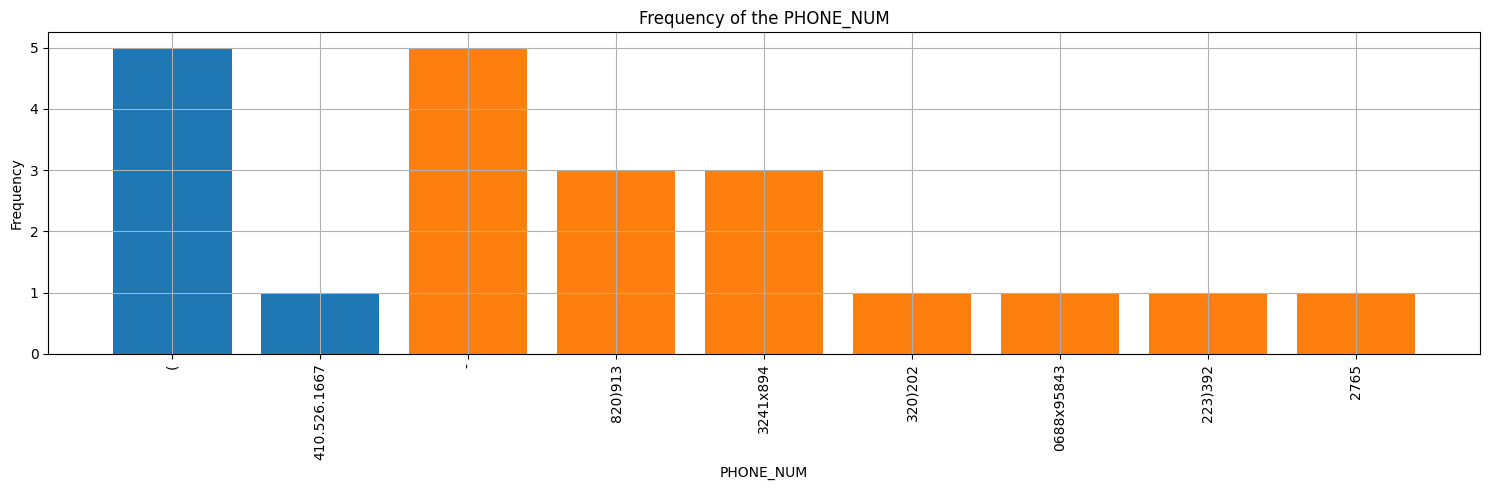

In [ ]:
phone_num_b = phone_num[phone_num["labels"] == "B-PHONE_NUM"]["tokens"].value_counts()
phone_num_i = phone_num[phone_num["labels"] == "I-PHONE_NUM"]["tokens"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(phone_num_b.index, phone_num_b)
plt.bar(phone_num_i.index, phone_num_i)

plt.title("Frequency of the PHONE_NUM")
plt.xlabel("PHONE_NUM")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Does phone numbers have white spaces between tokens

In [ ]:
phone_num = tmp_df.explode(["labels", "tokens", "trailing_whitespace"]).reset_index()

phone_num_b = phone_num[phone_num["labels"] == "B-PHONE_NUM"]["trailing_whitespace"].value_counts()
phone_num_i = phone_num[phone_num["labels"] == "I-PHONE_NUM"]["trailing_whitespace"].value_counts()

display(phone_num_b)
display(phone_num_i)

trailing_whitespace
False    5
True     1
Name: count, dtype: int64

trailing_whitespace
False    14
True      1
Name: count, dtype: int64

### Function

In [90]:
def is_phone(text):
    # Define the regular expression pattern to match phone numbers
    pattern = r'\(?(\d{3})\)?[. ]?(\d{3})[. ]?(\d{4})\b'

    # Find all matches of the pattern in the text
    # matches = re.findall(pattern, text)
    return re.match(pattern, text) is not None

    print(matches)
    # Process matches to format them properly
    phone_numbers = []
    for match in matches:
        formatted_number = ''.join(match)
        phone_numbers.append(formatted_number)

    return phone_numbers


def get_all_phone_num_from_text(df_exploded):
    output = {
        "document" : [],
        "token" : [], 
        "label" : [],
    }

    _label1 = "B-PHONE_NUM"
    _label2 = "I-PHONE_NUM"

    for document, token, token_id in zip(df_exploded["document"], df_exploded["tokens"], df_exploded["token"]):
        if token == "(":
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label1)
        elif is_phone(token):
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label2)
        elif str(token).isnumeric() and len(str(token)) == 10:
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label1)
        else:
            tt = str(token).replace(".","").replace("x","").replace(")","")
            if tt.isnumeric() and len(tt) >= 8 and len(tt) <= 10:
                output["document"].append(document)
                output["token"].append(token_id)
                output["label"].append(_label2)
    return output

output = get_all_phone_num_from_text(train_df_expl)
print(len(output["document"]))
print(output)

# Example usage:
# text = """
# Here are some phone numbers:
# (123) 456 7890,
# (987)6543210,
# 999.999.9999,
# 1234x12345,
# 1234567890
# """
# numbers = find_phone_numbers(text)
# print("Phone numbers found:", numbers)

11054
{'document': [7, 7, 7, 10, 10, 56, 56, 86, 86, 86, 86, 86, 112, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 136, 136, 166, 204, 214, 214, 214, 269, 288, 308, 308, 308, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 330, 330, 356, 356, 379, 379, 379, 379, 379, 470, 472, 472, 472, 472, 472, 609, 616, 616, 616, 616, 616, 651, 651, 651, 714, 736, 736, 736, 736, 828, 828, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1210, 1239, 1290, 1290, 1290, 1290, 1290, 1290, 1295, 1295, 1295, 1295, 1295, 1295, 1295, 1295, 1325, 1325, 1325, 1353, 1353, 1353, 1353, 1353, 1353, 1437, 1437, 1437, 1447, 1447, 1477, 1546, 1546, 1546, 1546, 1546, 1546, 1546, 1546, 1549, 1578, 1578, 1753, 1753, 1753, 1753, 1753, 1753, 1753, 1753, 1753, 1753, 1753, 1758, 1758, 1763, 1763, 1763, 1763, 1769, 1769, 1795, 1802, 1802, 1802, 1802, 1802, 1802, 1802, 1802, 1802, 1802, 1802, 1810, 2054, 2054, 2054, 2054, 2058, 2058, 2058, 2058, 2058, 2058, 2061, 2672, 2694, 2700, 2700, 2700, 270

## Deep Dive : STREET_ADDRESS
### Example STREET_ADDRESS

In [ ]:
street_add = tmp_df.explode(["labels", "tokens"]).reset_index()
street_add_b = street_add[street_add["labels"] == "B-STREET_ADDRESS"]["tokens"].tolist()
street_add_i = street_add[street_add["labels"] == "I-STREET_ADDRESS"]["tokens"].tolist()

print(f"B-STREET_ADDRESS ({len(list(set(street_add_b)))} / {len(street_add_b)}) : ", street_add_b[:10])
print(f"I-STREET_ADDRESS ({len(list(set(street_add_i)))} / {len(street_add_i)}) : ", street_add_i[:10])

B-STREET_ADDRESS (2 / 2) :  ['591', '743']
I-STREET_ADDRESS (16 / 20) :  ['Smith', 'Centers', 'Apt', '.', '656', '\n', 'Joshuamouth', ',', 'RI', '95963']


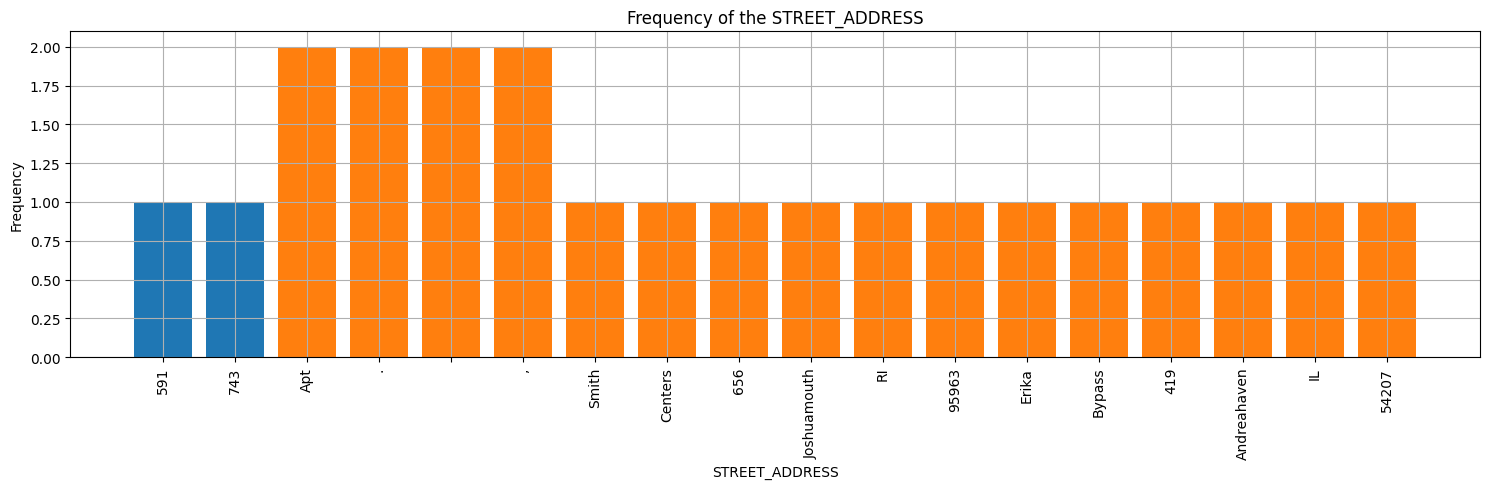

In [ ]:
street_add_b = street_add[street_add["labels"] == "B-STREET_ADDRESS"]["tokens"].value_counts()
street_add_i = street_add[street_add["labels"] == "I-STREET_ADDRESS"]["tokens"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(street_add_b.index, street_add_b)
plt.bar(street_add_i.index, street_add_i)

plt.title("Frequency of the STREET_ADDRESS")
plt.xlabel("STREET_ADDRESS")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Function

In [118]:
import re

def if_street_address(text):
    # Define a regular expression pattern to match street addresses
    address_pattern = r'\b\d{1,5}\s\w+\s\w+\b'

    # Find all matches of the pattern in the text
    # addresses = re.findall(address_pattern, text)
    return re.match(address_pattern, text) is not None
    return addresses


STREET_NAMES = ["street", "apt", "unit", "blvd", "bypass"]

def get_all_street_from_text(df_exploded):
    output = {
        "document" : [],
        "token" : [], 
        "label" : [],
    }

    _label1 = "B-STREET_ADDRESS"
    _label2 = "I-STREET_ADDRESS"

    for document, token, token_id in zip(df_exploded["document"], df_exploded["tokens"], df_exploded["token"]):
        if str(token).isnumeric() and len(token) == 3: 
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label1)
        elif if_street_address(token):
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label2)
        elif str(token).isalpha() and str(token).isupper() and len(token) == 2:
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label2)
        elif str(token).lower() in STREET_NAMES:
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label2)

    return output


# ts = train_df_expl[train_df_expl["labels"] == "B-STREET_ADDRESS"]["full_text"].values[0]
# print(ts)

# Example usage:
output = get_all_street_from_text(train_df_expl)
print(len(output["document"]))
print(output)

5356
{'document': [16, 104, 112, 123, 123, 123, 123, 166, 214, 214, 214, 214, 214, 214, 214, 214, 308, 308, 317, 317, 317, 324, 330, 330, 330, 330, 333, 333, 344, 344, 356, 379, 472, 472, 472, 609, 616, 828, 1210, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1290, 1290, 1290, 1290, 1290, 1437, 1546, 1578, 1613, 1613, 1613, 1753, 1758, 1763, 1769, 1769, 1795, 1810, 1810, 1817, 2651, 2694, 2745, 2745, 2745, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2769, 2797, 2797, 2828, 2828, 2828, 2828, 2828, 2828, 2828, 2901, 2995, 2995, 2995, 2995, 2995, 3211, 3211, 3211, 3211, 3211, 3211, 3211, 3211, 3211, 3214, 3214, 3231, 3231, 3241, 3249, 3249, 3328, 3402, 3423, 3427, 3446, 3553, 3579, 3579, 3678, 3678, 3686, 3709, 3709, 3709, 3709, 3756, 3756, 3756, 3786, 3786, 3786, 3786, 3786, 3885, 3885, 3885, 3885, 3885, 3885, 3911, 3911, 3911, 3911, 3911, 3915, 3915, 3968, 3987, 3987, 3987, 3987, 3987, 3987, 4004, 4040, 4070, 4070, 4070, 4176, 4214, 4214, 4227, 

## Deep Dive : URL_PERSONAL
### Example : URL_PERSONAL
- we can use regex to solve this

In [ ]:
url_pers = tmp_df.explode(["labels", "tokens"]).reset_index()
url_pers_b = url_pers[url_pers["labels"] == "B-URL_PERSONAL"]["tokens"].tolist()
url_pers_i = url_pers[url_pers["labels"] == "I-URL_PERSONAL"]["tokens"].tolist()

print(f"B-STREET_ADDRESS ({len(list(set(url_pers_b)))} / {len(url_pers_b)}) : ", url_pers_b[:10])
print(f"I-STREET_ADDRESS ({len(list(set(url_pers_i)))} / {len(url_pers_i)}) : ", url_pers_i[:10])

B-STREET_ADDRESS (95 / 110) :  ['https://www.jackson.com/list/explorehomepage.htm', 'https://www.linkedin.com/in/mmartinez', 'https://youtu.be/rFD2lJuvace', 'https://www.hall.biz/wp-contenthome.html', 'http://www.burns-lopez.com/categories/appabout.asp', 'http://jacobs-fisher.com/listpost.html', 'https://www.youtube.com/watch?v=n-ajTPJ1h-J', 'tps://www.facebook.com/bclark', 'https://www.youtube.com/channel/UC1ElAcppeuhfet', 'https://oconnell-townsend.com/wp-content/categorieshomepage.html']
I-STREET_ADDRESS (1 / 1) :  ['nYZqnhEXw']


/var/folders/bl/78xnml8j3qj74t4c1j3s2jhw0000gn/T/ipykernel_11228/3485205104.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


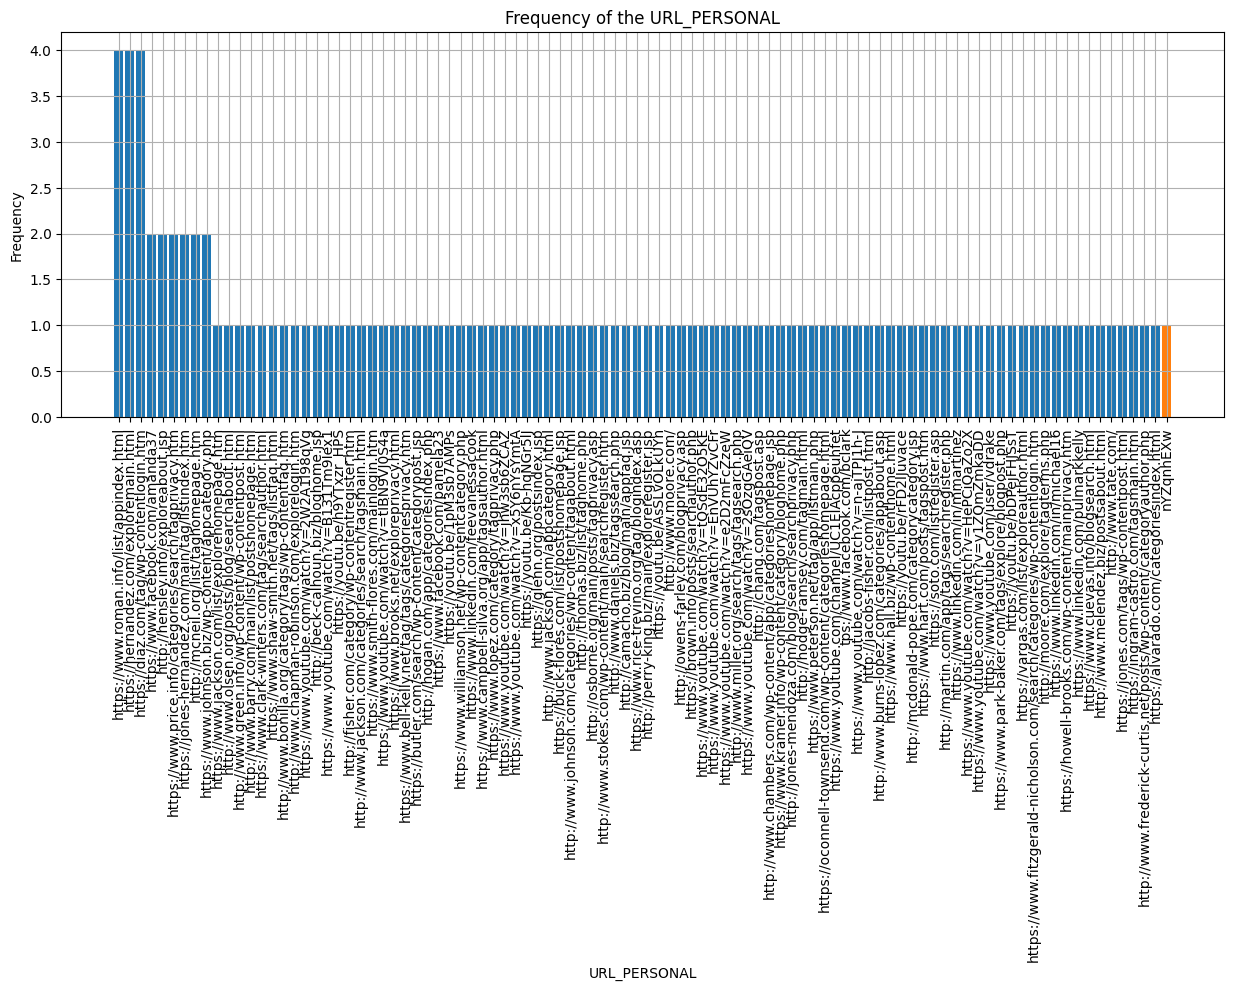

In [ ]:
url_pers_b = url_pers[url_pers["labels"] == "B-URL_PERSONAL"]["tokens"].value_counts()
url_pers_i = url_pers[url_pers["labels"] == "I-URL_PERSONAL"]["tokens"].value_counts()

plt.figure(figsize=(15,5))
plt.bar(url_pers_b.index, url_pers_b)
plt.bar(url_pers_i.index, url_pers_i)

plt.title("Frequency of the URL_PERSONAL")
plt.xlabel("URL_PERSONAL")
plt.ylabel("Frequency")
plt.grid()

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

### Function

In [84]:
def is_url(text):
    url_pattern = r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    return re.match(url_pattern, text) is not None

def get_all_url_from_text(df_exploded):
    output = {
        "document" : [],
        "token" : [], 
        "label" : [],
    }

    _label = "B-URL_PERSONAL"

    for document, token, token_id in zip(df_exploded["document"], df_exploded["tokens"], df_exploded["token"]):
        if is_url(token):
            output["document"].append(document)
            output["token"].append(token_id)
            output["label"].append(_label)
    return output

output = get_all_url_from_text(train_df_expl)
print(output)



{'document': [123, 123, 123, 123, 123, 123, 123, 136, 317, 379, 472, 1309, 1447, 1798, 2672, 2700, 2722, 3202, 3402, 3592, 3709, 3709, 3709, 3709, 3709, 3709, 3786, 3894, 3911, 4094, 4094, 4094, 4094, 4094, 4094, 4094, 4094, 4185, 4381, 4381, 4381, 4381, 4381, 4381, 4381, 4394, 4553, 4842, 4842, 5083, 5433, 5662, 5923, 5923, 6007, 6194, 6257, 6257, 6393, 6426, 6426, 6457, 6459, 6459, 6611, 6694, 6694, 6694, 6754, 6784, 6830, 6853, 6859, 7000, 7137, 7137, 7137, 7308, 7308, 7408, 7680, 7680, 7713, 7713, 7713, 7733, 7858, 7858, 8011, 8011, 8011, 8076, 8123, 8302, 8302, 8416, 8416, 8491, 8688, 8803, 8803, 8902, 8909, 8954, 8954, 9067, 9110, 9117, 9117, 9138, 9203, 9297, 9297, 9297, 9297, 9297, 9297, 9358, 9358, 9421, 9470, 9470, 9470, 9470, 9589, 9590, 9590, 9590, 9665, 9801, 9854, 9892, 9892, 9892, 10008, 10024, 10057, 10145, 10147, 10147, 10147, 10236, 10291, 10325, 10356, 10356, 10418, 10418, 10517, 10561, 10609, 10617, 10617, 10617, 10617, 10617, 10617, 10621, 10662, 10662, 10674, 1067

### Figure out which label has connecting elements
- Email and username are singe tokens
- All other categories are multiple tokens


In [ ]:
unique_labels = tmp_df["labels"].explode().value_counts().to_dict()
unique_labels = dict(sorted(unique_labels.items(), key=lambda x : x[0].split("-")[1] if x[0] != "O" else ""))

label_cat = {}
del unique_labels["O"]


for k in unique_labels:
    cat = k.split("-")[1]
    cont = k.split("-")[0]
    if cat not in label_cat:
        label_cat[cat] = []
    label_cat[cat].append(cont)

print(label_cat)


{'EMAIL': ['B'], 'ID_NUM': ['B', 'I'], 'NAME_STUDENT': ['B', 'I'], 'PHONE_NUM': ['I', 'B'], 'STREET_ADDRESS': ['I', 'B'], 'URL_PERSONAL': ['B', 'I'], 'USERNAME': ['B']}


# Summary : Brute force Approach

> List of classes:
1) EMAIL
2) ID_NUM
3) NAME_STUDENT
4) PHONE_NUM
5) STREET_ADDRESS
6) URL_PERSONAL
7) USERNAME

### EMAIL (only B): -DONE
- Since they are single tokens, we can just use a regex match to obtain them

### ID_NUM
- There is only one I-continuity, we can omit them
- General rule based algorithm. If the continuous numbers crosses 11 digits, I can classify them as ID_NUM. 
- I will be losing some id_num where the digits are less than 11 digit. but from the training set, its less than 5 counts

### NAME_STUDENT
- Since they are names, we can use a simple rule based algorithm to check whether the given word is a name or not.

### PHONE_NUM:
- We can use regex matching by combining the tokens

### STREET_ADDRESS
- For street address, I need to 

### URL_PERSONAL (only B):
- The I continuity happens very low. So we can use a brute force approach and disregard them. Use a regex to find the urls

### USERNAME:
- We can use brute force solution of maintaining all the username examples from the training data and then trying to figure out whether it matches



# Run Evaluation metric

In [126]:
email_checker       = get_all_emails_from_text
username_checker    = get_all_usernames_from_text
id_num_checker      = get_all_idnum_from_text
name_stud_checker   = get_all_name_from_text
phone_num_checker   = get_all_phone_num_from_text
street_add_checker  = get_all_street_from_text
url_checker         = get_all_url_from_text


email_output_df     = pd.DataFrame(email_checker(train_df_expl))
print("[DONE] EMAIL")

username_output_df  = pd.DataFrame(username_checker(train_df_expl))
print("[DONE] USERNAME")

id_num_output_df    = pd.DataFrame(id_num_checker(train_df_expl))
print("[DONE] ID_NUM")

name_output_df      = pd.DataFrame(name_stud_checker(train_df_expl))
print("[DONE] NAME_STUDENT")

phone_output_df     = pd.DataFrame(phone_num_checker(train_df_expl))
print("[DONE] PHONE_NUM")

street_output_df    = pd.DataFrame(street_add_checker(train_df_expl))
print("[DONE] STREET_ADDRESS")

url_output_df       = pd.DataFrame(url_checker(train_df_expl))
print("[DONE] URL_PERSONAL")


[DONE] EMAIL
[DONE] USERNAME
[DONE] ID_NUM
[DONE] NAME_STUDENT
[DONE] PHONE_NUM
[DONE] STREET_ADDRESS
[DONE] URL_PERSONAL


In [128]:
pred_df = pd.concat([email_output_df, username_output_df, id_num_output_df, name_output_df, phone_output_df, street_output_df, url_output_df])
pred_df.drop_duplicates(subset=["document", "token"])

print(len(pred_df))
pred_df.head()

pred_df.to_csv("sample_pred.csv", sep = ",", index=False, encoding="utf-8")


19377


In [130]:
train_df = pd.read_json(open(data_path + "train.json"))
train_df["document"].max()

pred_df = pd.read_csv("sample_pred rule based.csv")
pred_df["document"].max()

print("total len of pred_df : ", len(pred_df))

# create a copy
train_df_clean = train_df.copy()

def create_token_list(token_list):
  return list(range(len(token_list)))  # Create list based on current list length

train_df_clean["token"] = train_df_clean["tokens"].apply(create_token_list)

# explode the columns "tokens" and "labels"
train_df_clean = train_df_clean.explode(["tokens", "labels", "token"], ignore_index=True)

# drop the unnecessary columns
train_df_clean.drop(columns=["full_text", "trailing_whitespace"], inplace=True)

# rename the columns
train_df_clean.rename(columns={"tokens" : "token_str", "labels" : "label"}, inplace=True)

# create a new column "token"
# train_df_clean["token"] = train_df_clean.index

# filter the rows based on label
train_df_clean = train_df_clean[train_df_clean["label"] != "O"]

# reset the index again
train_df_clean.reset_index(drop=True, inplace=True)

# create a column "row_id"
train_df_clean["row_id"] = train_df_clean.index

train_df_clean.head()

print("total len of train_df_cleaned : ", len(train_df_clean))
print("Total NA : ")
print(train_df_clean.isna().sum())


total len of pred_df :  19377
total len of train_df_cleaned :  2739
Total NA : 
document     0
token_str    0
label        0
token        0
row_id       0
dtype: int64


In [132]:
train_df_clean_copy = train_df_clean.drop(columns=["row_id", "token_str"])

comb_df = pd.merge(pred_df, train_df_clean_copy, how="outer", suffixes=("","_pred"), on=["token", "document"])
print("total len of comb_df : ", len(comb_df))
display(comb_df.isna().sum())

comb_df.fillna("O", inplace=True)

display(comb_df.isna().sum())


total len of comb_df :  21107


document          0
token             0
label          1730
label_pred    17583
dtype: int64

document      0
token         0
label         0
label_pred    0
dtype: int64

['B-EMAIL' 'B-ID_NUM' 'B-NAME_STUDENT' 'B-PHONE_NUM' 'B-STREET_ADDRESS'
 'B-URL_PERSONAL' 'B-USERNAME' 'I-ID_NUM' 'I-NAME_STUDENT' 'I-PHONE_NUM'
 'I-STREET_ADDRESS' 'I-URL_PERSONAL' 'O']


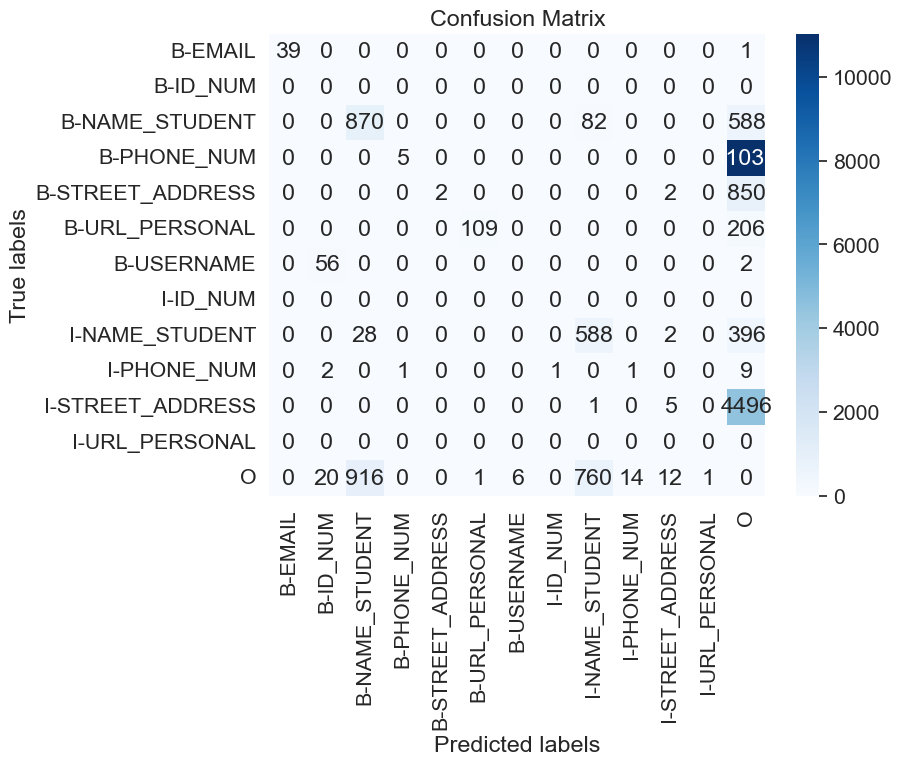

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = comb_df["label"]
y_pred = comb_df["label_pred"]

labels = np.unique(np.concatenate((y_true, y_pred)))
print(labels)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [135]:
from sklearn.metrics import fbeta_score

score = fbeta_score(y_true, y_pred, beta=5, average="weighted")
print("F Beta Score : ", score)

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

f1_score = f1_score(y_true, y_pred, average="weighted")
print("F1 Score : ", score)

acc_score = accuracy_score(y_true, y_pred)
print("Accuracy Score : ", acc_score)

prec_score = precision_score(y_true, y_pred, average="weighted")
print("Precision Score : ", prec_score)

recall_score = recall_score(y_true, y_pred, average="weighted")
print("Recall Score : ", recall_score)

F Beta Score :  0.07614740193774905
F1 Score :  0.07614740193774905
Accuracy Score :  0.07670441085895674
Precision Score :  0.5985794902667021
Recall Score :  0.07670441085895674


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
